In [3]:
import os
import sys
custom_paths = ['../src/']
for path in custom_paths:
    if os.path.abspath(path) not in sys.path:
        sys.path.insert(0, os.path.abspath(path))
print(sys.path)

['/nfs/home/cybai/PyTorch-StudioGAN/src', '/nfs/home/cybai/PyTorch-StudioGAN/notebooks', '/home/cybai/miniconda3/envs/studiogan/lib/python37.zip', '/home/cybai/miniconda3/envs/studiogan/lib/python3.7', '/home/cybai/miniconda3/envs/studiogan/lib/python3.7/lib-dynload', '', '/home/cybai/miniconda3/envs/studiogan/lib/python3.7/site-packages', '/home/cybai/miniconda3/envs/studiogan/lib/python3.7/site-packages/IPython/extensions', '/nfs/home/cybai/.ipython']


In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import functools
from importlib import reload
from matplotlib import pyplot as plt
import scipy
from scipy import stats
from scipy.special import softmax
import os
import ast
import glob

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

import torch
from torch.nn import Parameter as P
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# from src.metrics.feat_extract_models import alexnet, inception, vgg

from utils.load_checkpoint import load_checkpoint
from metrics.FID import calculate_frechet_distance
from metrics.feat_extract_models import alexnet, inception, vgg
reload(alexnet)
reload(inception)
reload(vgg)

import misc
reload(misc)

<module 'misc' from '/nfs/home/cybai/PyTorch-StudioGAN/notebooks/misc.py'>

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = 'cuda'
torch.backends.cudnn.benchmark = True

In [6]:
tinyimagenet_train_dset = datasets.ImageFolder(
    '/tmp2/cybai/tiny-imagenet/tiny-imagenet-200/train',
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])) # range = [-1, 1]
tinyimagenet_test_dset = datasets.ImageFolder(
    '/tmp2/cybai/tiny-imagenet/tiny-imagenet-200/val',
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])) # range = [-1, 1]

In [7]:
ys = np.unique([y for x, y in tinyimagenet_train_dset])
ys

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [8]:
proj_model = inception.WrappedInception3(custom_num_classes=200).to(device)

##### trainable parameters
AuxLogits.fc.weight	AuxLogits.fc.bias	fc.weight	fc.bias	
#####


In [9]:
params_to_update = [p for p in proj_model.parameters() if p.requires_grad]

In [10]:
lr = 0.001
momentum = 0.9
optimizer = torch.optim.SGD(params_to_update, lr=lr, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.975)
criterion = torch.nn.CrossEntropyLoss()

In [11]:
proj_model.train()

WrappedInception3(
  (net): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): B

In [12]:
n_epochs = 20
train_dset = datasets.ImageFolder(
    '/tmp2/cybai/tiny-imagenet/tiny-imagenet-200/train',
    transform=transforms.Compose([transforms.RandomResizedCrop(299), transforms.RandomHorizontalFlip(), 
                                  transforms.ToTensor(), transforms.Normalize(0.5, 0.5)]))
train_dl = DataLoader(train_dset, batch_size=64, shuffle=True, num_workers=8, drop_last=True)
eval_train_dset = datasets.ImageFolder(
    '/tmp2/cybai/tiny-imagenet/tiny-imagenet-200/train',
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)]))
eval_train_dl = DataLoader(eval_train_dset, batch_size=64, shuffle=False, num_workers=8, drop_last=False)
eval_val_dset = datasets.ImageFolder(
    '/tmp2/cybai/tiny-imagenet/tiny-imagenet-200/val',
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)]))
eval_val_dl = DataLoader(eval_val_dset, batch_size=64, shuffle=False, num_workers=8, drop_last=False)

for epoch in range(1, n_epochs + 1):
    proj_model.train()
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        _, outputs, aux_outputs = proj_model(x)
        loss = criterion(outputs, y) + 0.4 * criterion(aux_outputs, y)

        _, preds = torch.max(outputs, 1)

        loss.backward()
        optimizer.step()

    print(f'epoch {epoch}:', end=' ')
    proj_model.eval()
    with torch.no_grad():
        for mode, dl in [('train', eval_train_dl), ('val', eval_val_dl)]:
            n_corrects = 0
            n_totals = 0
            for x, y in dl:
                x, y = x.to(device), y.to(device)
                _, outputs = proj_model(x)
                _, preds = torch.max(outputs, 1)
                # statistics
                n_corrects += torch.sum(preds == y.data).double()
                n_totals += y.data.shape[0]
            acc = n_corrects / n_totals
            print(f'{mode}_acc={acc:.4f}', end=' ')
    print('')

    scheduler.step()

epoch 1: train_acc=0.1185 val_acc=0.1129 
epoch 2: train_acc=0.1524 val_acc=0.1510 
epoch 3: train_acc=0.1872 val_acc=0.1857 
epoch 4: train_acc=0.2061 val_acc=0.2040 
epoch 5: train_acc=0.2713 val_acc=0.2650 
epoch 6: train_acc=0.2494 val_acc=0.2436 
epoch 7: train_acc=0.2800 val_acc=0.2693 
epoch 8: train_acc=0.3006 val_acc=0.2911 
epoch 9: train_acc=0.3074 val_acc=0.2994 
epoch 10: train_acc=0.3249 val_acc=0.3208 
epoch 11: train_acc=0.3397 val_acc=0.3344 
epoch 12: train_acc=0.3326 val_acc=0.3261 
epoch 13: train_acc=0.3347 val_acc=0.3257 
epoch 14: train_acc=0.3247 val_acc=0.3164 
epoch 15: train_acc=0.3361 val_acc=0.3288 
epoch 16: train_acc=0.3530 val_acc=0.3436 
epoch 17: train_acc=0.3450 val_acc=0.3331 
epoch 18: train_acc=0.3352 val_acc=0.3231 
epoch 19: train_acc=0.3606 val_acc=0.3498 
epoch 20: train_acc=0.3548 val_acc=0.3517 


In [38]:
proj_model.eval()

WrappedInception3(
  (net): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): B

In [6]:
ref_dsets = {'tiny_train': tinyimagenet_train_dset, 'tiny_val': tinyimagenet_test_dset}
ref_dls = {k: DataLoader(v, batch_size=50, shuffle=False, num_workers=8, drop_last=False)
           for k, v in ref_dsets.items()}

In [11]:
dset_feats = {}
for dset_name, dl in ref_dls.items():
    print(dset_name)
    feats_, logits_ = misc.project(dl, proj_model, to_numpy=True)
    # top_1_conf = np.amax(softmax(logits_, axis=-1), axis=-1)
    dset_feats[dset_name] = feats_

tiny_train
tiny_val


In [12]:
nnds, _ = misc.calculate_knnd_numpy(target_feats=dset_feats['tiny_val'], 
                                    ref_feats=dset_feats['tiny_train'])
nnds.shape

(10000,)

Text(0.5, 0, 'nnd')

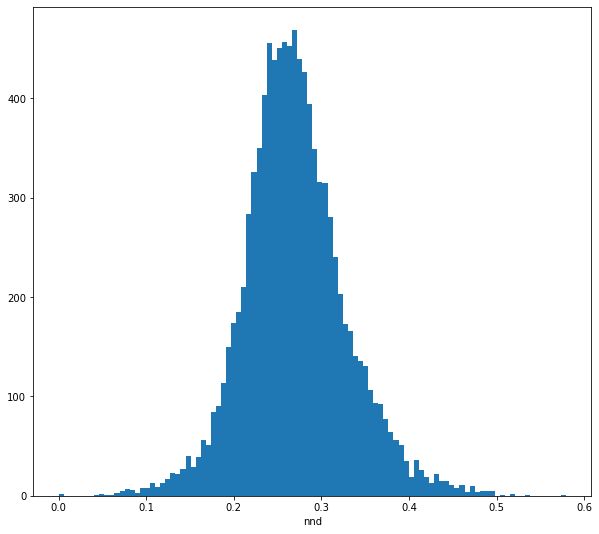

In [16]:
plt.figure(figsize=(10, 9))
plt.hist(nnds, bins=100)
plt.xlabel('nnd')